In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

In [3]:
def process_data(file, year):
    df = pd.read_csv(file, parse_dates=['Date'])
    df = df[['Date', 'Daily Max 1-hour NO2 Concentration']].dropna()
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df = df[df['Year'] == year]
    monthly_avg = df.groupby('Month')['Daily Max 1-hour NO2 Concentration'].mean().reset_index()
    monthly_avg['Year'] = year
    return monthly_avg.rename(columns={'Daily Max 1-hour NO2 Concentration': 'NO2 Concentration'})


In [5]:
data_2023 = process_data('Datasets\dataset_2023.csv', 2023)
data_2024 = process_data('Datasets\dataset_2024.csv', 2024)
train_df = pd.concat([data_2023, data_2024], ignore_index=True)

In [6]:
train_df['Year_2023'] = (train_df['Year'] == 2023).astype(int)
train_df['Year_2024'] = (train_df['Year'] == 2024).astype(int)
train_df['Year_2025'] = 0

In [7]:
for m in range(1, 13):
    train_df[f'Month_{m}'] = (train_df['Month'] == m).astype(int)

In [8]:
cols = ['NO2 Concentration', 'Year_2023', 'Year_2024', 'Year_2025'] + [f'Month_{m}' for m in range(1, 13)]
train_df = train_df[cols]

In [9]:
train_df.to_csv('no2_train_data.csv', index=False)

In [10]:
X_train = train_df.drop(columns=['NO2 Concentration'])
y_train = train_df['NO2 Concentration']

model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
test_df = process_data('Datasets\dataset_2025.csv', 2025)
test_df['Year_2023'] = 0
test_df['Year_2024'] = 0
test_df['Year_2025'] = 1

In [12]:
for m in range(1, 13):
    test_df[f'Month_{m}'] = (test_df['Month'] == m).astype(int)

In [13]:
test_df = test_df.rename(columns={'NO2 Concentration': 'NO2 Concentration'})
test_df = test_df[['NO2 Concentration', 'Year_2023', 'Year_2024', 'Year_2025'] + [f'Month_{m}' for m in range(1, 13)]]

In [14]:
test_df.to_csv('no2_test_data_2025.csv', index=False)

In [15]:
X_test = test_df.drop(columns=['NO2 Concentration'])
y_test = test_df['NO2 Concentration']
y_pred = model.predict(X_test)

In [18]:
meses_disponibles = test_df[[f'Month_{m}' for m in range(1, 13)]].idxmax(axis=1)
meses_disponibles = meses_disponibles.str.extract(r'(\d+)').astype(int)[0].tolist()

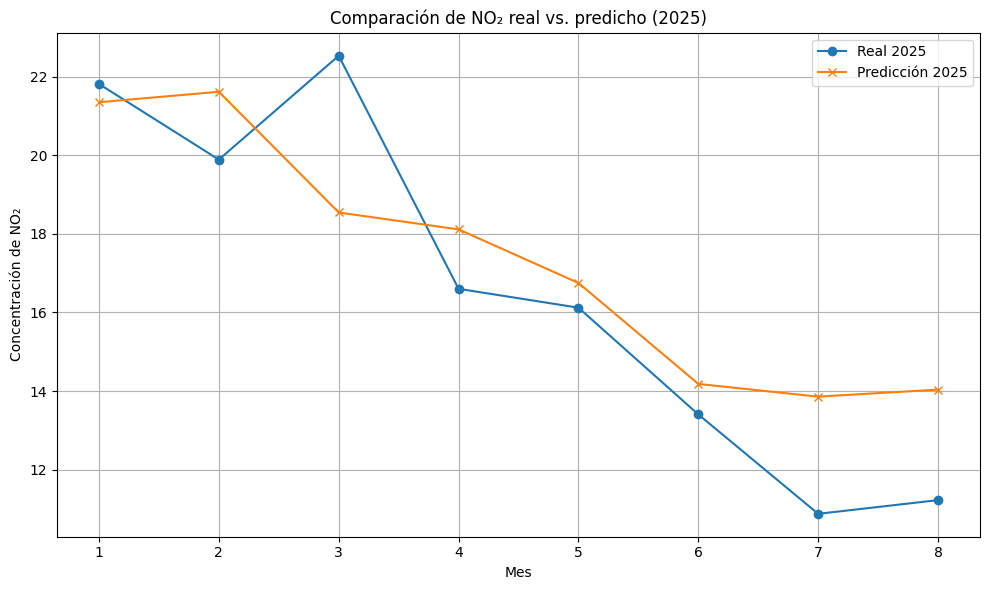

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(meses_disponibles, y_test, label='Real 2025', marker='o')
plt.plot(meses_disponibles, y_pred, label='Predicción 2025', marker='x')
plt.xticks(meses_disponibles)
plt.xlabel('Mes')
plt.ylabel('Concentración de NO₂')
plt.title('Comparación de NO₂ real vs. predicho (2025)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("comparacion_NO2_2025.png")
plt.show()

In [23]:
def consultar_mes():
    meses_idx = {
        int(col.split('_')[1]): idx
        for idx, col in test_df[[f'Month_{m}' for m in range(1, 13)]].idxmax(axis=1).items()
    }

    while (entrada := input("\n🔍 Mes (1-12) o 'salir': ").lower()) != 'salir':
        if not entrada.isdigit() or not (1 <= int(entrada) <= 12):
            print("⚠️ Entrada inválida."); continue

        mes = int(entrada)
        input_row = pd.DataFrame([{
            'Year_2023': 0, 'Year_2024': 0, 'Year_2025': 1,
            **{f'Month_{m}': int(m == mes) for m in range(1, 13)}
        }])
        pred = model.predict(input_row)[0]
        print(f"\n📅 Mes {mes}\n🔮 Predicción NO₂: {round(pred, 2)}")

        real = round(y_test.iloc[meses_idx[mes]], 2) if mes in meses_idx else None
        print(f"📊 Valor real NO₂: {real}" if real is not None else "❌ No hay dato real disponible.")
consultar_mes()


📅 Mes 1
🔮 Predicción NO₂: 21.35
📊 Valor real NO₂: 21.81

📅 Mes 3
🔮 Predicción NO₂: 18.54
📊 Valor real NO₂: 22.53

📅 Mes 8
🔮 Predicción NO₂: 14.04
📊 Valor real NO₂: 11.22

📅 Mes 9
🔮 Predicción NO₂: 16.58
❌ No hay dato real disponible.
